# Прогнозирование оттока клиентов оператора связи "ТелеДом"

**Описание проекта**

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Ваша задача — обучить на этих данных модель для прогноза оттока клиентов.

**Описание услуг**

Оператор предоставляет два основных типа услуг:
- Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.
- Интернет. Подключение может быть двух типов: через телефонную линию (`DSL`, от англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (`Fiber optic`).

Также доступны такие услуги:
- Интернет-безопасность: антивирус (`DeviceProtection`) и блокировка небезопасных сайтов (`OnlineSecurity`);
- Выделенная линия технической поддержки (`TechSupport`);
- Облачное хранилище файлов для резервного копирования данных (`OnlineBackup`);
- Стриминговое телевидение (`StreamingTV`) и каталог фильмов (`StreamingMovies`).

Клиенты могут платить за услуги каждый месяц или заключить договор на 1–2 года. Возможно оплатить счёт разными способами, а также получить электронный чек.


**Описание данных**

Данные состоят из нескольких файлов, полученных из разных источников:
- `contract_new.csv` — информация о договоре;
- `personal_new.csv` — персональные данные клиента;
- `internet_new.csv` — информация об интернет-услугах;
- `phone_new.csv` — информация об услугах телефонии.

Файл `contract_new.csv`:
- `customerID` — идентификатор абонента;
- `BeginDate` — дата начала действия договора;
- `EndDate` — дата окончания действия договора;
- `Type` — тип оплаты: раз в год-два или ежемесячно;
- `PaperlessBilling` — электронный расчётный лист;
- `PaymentMethod` — тип платежа;
- `MonthlyCharges` — расходы за месяц;
- `TotalCharges` — общие расходы абонента.

Файл `personal_new.csv`:
- `customerID` — идентификатор пользователя;
- `gender` — пол;
- `SeniorCitizen` — является ли абонент пенсионером;
- `Partner` — есть ли у абонента супруг или супруга;
- `Dependents` — есть ли у абонента дети.

Файл `internet_new.csv`:
- `customerID` — идентификатор пользователя;
- `InternetService` — тип подключения;
- `OnlineSecurity` — блокировка опасных сайтов;
- `OnlineBackup` — облачное хранилище файлов для резервного копирования данных;
- `DeviceProtection` — антивирус;
- `TechSupport` — выделенная линия технической поддержки;
- `StreamingTV` — стриминговое телевидение;
- `StreamingMovies` — каталог фильмов.

Файл `phone_new.csv`:
- `customerID` — идентификатор пользователя;
- `MultipleLines` — подключение телефона к нескольким линиям одновременно.

Во всех файлах столбец customerID содержит код клиента. Информация о договорах актуальна на 1 февраля 2020 года.
Данные также находятся в тренажёре, в папке `/datasets/`.


## Подготовка данных

### Загрузка библиотек в тетрадь

In [1]:
!pip install -q -U numpy pandas tqdm scikit-learn catboost lightgbm phik seaborn matplotlib

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.56.0 requires numpy<1.23,>=1.18, but you have numpy 1.24.4 which is incompatible.


После установки новых версий библиотек следует перезапустить среду выполнения

In [2]:
# Базовые библиотеки
import numpy as np
import pandas as pd

# Полоса прогресса
from tqdm import tqdm, notebook
tqdm.pandas()

# Вспомогательные библиотеки
import os
import time
import re

# Предобработка данных
from sklearn.preprocessing import (
    MaxAbsScaler,
    PowerTransformer,
    OneHotEncoder,
    OrdinalEncoder,
)

# Выбор модели и трансформация данных
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Включение экспериментальных функций
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

# Модели
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import ComplementNB
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

# Метрики
from sklearn.metrics import (
    roc_curve,
    auc,
    roc_auc_score,
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

# Анализ мультиколлинеарности
import phik

# Библиотеки визуализации
import seaborn as sns
from pandas.plotting import scatter_matrix
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams, rcParamsDefault
%matplotlib inline

### Оптимизация отображения контента

In [3]:
# Данные подобраны для fullhd разрешения

# Отображение всех столбцов таблицы
pd.set_option('display.max_columns', None)

# Установка размера графиков
rcParams['figure.figsize'] = 12, 7

# Настройка формата графиков для встроенных изображений
%config InlineBackend.figure_format = 'svg'

# Дополнительные настройки для качественного отображения графиков
factor = 0.9  # Масштабирование DPI
default_dpi = rcParamsDefault['figure.dpi']  # Значение DPI по умолчанию
rcParams['figure.dpi'] = default_dpi * factor  # Установка значения DPI

### Глобальные переменные

In [4]:
# Константы
RANDOM_STATE = 18032024
TEST_SIZE = .25

## Загрузка данных

In [5]:
# Функция загрузки данных из файлов в датафреймы
def read_files(file_name):

    data = pd.DataFrame()

    path_1 = 'datasets/' + file_name + '.csv'
    path_2 = '/datasets/' + file_name + '.csv'
    path_3 = 'https://code.s3.yandex.net/datasets/' + file_name + '.csv'

    if os.path.exists(path_1):
        data = pd.read_csv(path_1)
    elif os.path.exists(path_2):
        data = pd.read_csv(path_2)
    elif os.path.exists(path_3):
        data = pd.read_csv(path_3)

    return data

In [6]:
# Загрузка файла "contract_new.csv" — информация о договоре
np.random.seed(RANDOM_STATE)
contract_new = read_files('contract_new')

# Анализ данных из файла
contract_new.sample(n=5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
4451,1608-GMEWB,2016-05-01,No,Month-to-month,Yes,Bank transfer (automatic),93.90,4225.5
6957,3914-FDRHP,2019-05-01,No,Month-to-month,No,Electronic check,86.25,830.59
5249,5115-GZDEL,2014-02-01,No,Two year,No,Credit card (automatic),67.20,5031.94
2727,3387-VATUS,2019-06-01,No,Month-to-month,Yes,Bank transfer (automatic),94.85,758.8
646,0887-HJGAR,2019-11-01,No,Month-to-month,Yes,Mailed check,45.70,141.21


In [7]:
# Загрузка файла "personal_new.csv" — персональные данные клиента
np.random.seed(RANDOM_STATE)
personal_new = read_files('personal_new')

# Анализ данных из файла
personal_new.sample(n=5)

,customerID,gender,SeniorCitizen,Partner,Dependents
4451,1608-GMEWB,Male,1,No,No
6957,3914-FDRHP,Male,0,No,No
5249,5115-GZDEL,Male,0,No,Yes
2727,3387-VATUS,Male,0,No,No
646,0887-HJGAR,Male,0,No,No


In [8]:
# Загрузка файла "internet_new.csv" — информация об интернет-услугах
np.random.seed(RANDOM_STATE)
internet_new = read_files('internet_new')

# Анализ данных из файла
internet_new.sample(n=5)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1658,3106-ULWFW,Fiber optic,No,No,No,No,No,Yes
2321,6898-MDLZW,DSL,No,Yes,No,Yes,No,No
2118,0254-KCJGT,DSL,Yes,Yes,Yes,Yes,No,Yes
2768,1530-ZTDOZ,DSL,Yes,No,No,No,Yes,No
1435,3536-IQCTX,Fiber optic,No,No,No,No,No,Yes


In [9]:
# Загрузка файла "phone_new.csv" — информация об услугах телефонии
np.random.seed(RANDOM_STATE)
phone_new = read_files('phone_new')

# Анализ данных из файла
phone_new.sample(n=5)

,customerID,MultipleLines
3704,6199-IPCAO,Yes
5137,1121-QSIVB,Yes
3309,0512-FLFDW,Yes
591,1140-UKVZG,Yes
3786,7858-GTZSP,Yes


## Исследовательский анализ и предобработка данных

In [10]:
def get_unique_counts(data):
    # Подсчет уникальных значений для всех столбцов
    unique_counts = data.apply(lambda x: x.value_counts().count())

    # Вывод результатов в красивом формате
    print("Количество уникальных значений для каждого столбца:")
    print(unique_counts.to_string())

In [11]:
def plot_pie_charts(data, features, shape_=None):
    num_features = len(features)
    if isinstance(shape_, list) and len(shape_) == 2:
        num_rows, num_cols = shape_
    else:
        num_cols = 3
        num_rows = num_features // num_cols + (num_features % num_cols > 0)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))
    axes = axes.flatten()

    colors = sns.color_palette("pastel")

    for i, feature in enumerate(features):
        labels = data[feature].value_counts().index
        sizes = data[feature].value_counts().values

        wedges, texts, autotexts = axes[i].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
        for wedge in wedges:
            wedge.set_edgecolor('black')

        axes[i].set_title(feature)

    plt.tight_layout()
    plt.show()

In [12]:
def plot_hist(data, features, bins=10):
    num_features = len(features)
    num_cols = 3
    num_rows = num_features // num_cols + (num_features % num_cols > 0)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))
    axes = axes.flatten()

    colors = sns.color_palette("pastel")

    for i, feature in enumerate(features):
        sns.histplot(data[feature], ax=axes[i], color=colors[i % len(colors)], bins=bins, kde=True)
        axes[i].set_title(feature)
        axes[i].set_xlabel(None)
        axes[i].set_ylabel(None)
        axes[i].grid(True)

    plt.tight_layout()
    plt.show()

In [13]:
def preprocess_column_names(dataframe):
    dataframe.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower() for i in dataframe.columns]
    dataframe = dataframe.rename(columns={'customer_i_d':'customer_id',
    'streaming_t_v':'streaming_tv'})
    return dataframe

In [14]:
def show_data(data, seed):
    display(data.info())
    np.random.seed(seed)
    display(data.sample(n=5))

### Анализ и предобработка `contract_new` (информация о договоре)

In [15]:
show_data(contract_new, RANDOM_STATE)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
4451,1608-GMEWB,2016-05-01,No,Month-to-month,Yes,Bank transfer (automatic),93.90,4225.5
6957,3914-FDRHP,2019-05-01,No,Month-to-month,No,Electronic check,86.25,830.59
5249,5115-GZDEL,2014-02-01,No,Two year,No,Credit card (automatic),67.20,5031.94
2727,3387-VATUS,2019-06-01,No,Month-to-month,Yes,Bank transfer (automatic),94.85,758.8
646,0887-HJGAR,2019-11-01,No,Month-to-month,Yes,Mailed check,45.70,141.21


In [16]:
contract_new.duplicated().sum()

0

In [17]:
contract_new['customerID'].duplicated().sum()

0

In [18]:
# Подсчет уникальных значений для всех столбцов
get_unique_counts(contract_new)

Количество уникальных значений для каждого столбца:
customerID          7043
BeginDate             77
EndDate               67
Type                   3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6658


**Предварительные выводы**

1. Датафрейм `contract_new` содержит 8 признаков и 7043 объекта.
1. Датафрейм не содержит пропусков.
1. Признак `customerID` содерижт идентификаторы клиентов.
1. Признаки `BeginDate` и `EndDate` содержат информацию о дате и месяце начала и окончания действия договора соответственно. Если `EndDate` содержит `No`, значит договор был активен 01.02.2020. Оба признака требуется удалить из датафрейма, т.к. они "привязаны" к определенным временным промежуткам и приведут к ошибочным предсказаниям при использовании более поздних дат. Перед их удалением на их основе требуется создать признаки `active_contract` и `duration_contract`. Для корректного расчета продолжительности контракта, после создания поризнака `active_contract` и до создания `duration_contract` следует значения `No` признака `EndDate` заменить на числовое значение `2020-02-01` (актуальная дата информации, согласно данным от руководителя проекта).

Для корректной предварительной обработки данных, содержащихся в DataFrame contract_new, следует произвести следующие этапы:

1. Создание признака active_contract, который отражает активность договора и определяется как бинарный индикатор: 0 в случае, если значение столбца EndDate равно "No", и 1 в противном случае.
1. Замена значений "No" в столбце EndDate на дату 2020-02-01, представляющую последний актуальный день согласно указаниям руководства проекта.
1. Создание признака duration_contract, который определяет продолжительность действия договора. Этот признак вычисляется как разность между датой начала действия договора (BeginDate) и датой окончания действия договора (EndDate), выраженная в единицах времени, например, днях.
1. Преобразование столбца TotalCharges к числовому формату (float64) и замена пробелов в данном столбце на числовое значение, такое как 0.
1. Пропущенные значения в столбце TotalCharges вероятно указывают на отсутствие оплаты.
1. Приведение названий признаков к формату "змеиного стиля" (snake_case) для обеспечения единообразия и удобства в последующем анализе данных.


In [19]:
# Создание признака "active_contract":
contract_new['active_contract'] = (contract_new['EndDate'] != 'No').astype(int)

In [20]:
# Оптимизация типа данных признака "BeginDate" и "EndDate" и создание признака "duration_contract":
contract_new['BeginDate'] = pd.to_datetime(contract_new['BeginDate'], format='%Y-%m-%d')
contract_new['EndDate'] = pd.to_datetime(contract_new['EndDate'].replace('No', '2020-02-01'), format='%Y-%m-%d')
contract_new['duration_contract'] = (contract_new['EndDate'] - contract_new['BeginDate']).dt.days

# Удаление признаков "BeginDate" и "EndDate"
contract_new.drop(['BeginDate', 'EndDate'], axis=1, inplace=True)

In [23]:
contract_new['TotalCharges'].value_counts()

TotalCharges
           11
20.45       6
101.0       5
21.53       4
40.1        4
           ..
4357.5      1
3509.55     1
2530.8      1
2599.1      1
7251.82     1
Name: count, Length: 6658, dtype: int64

In [25]:
# Проверка на наличие не числовых значений в "TotalCharges"
contract_new.loc[
    contract_new['TotalCharges'].str.contains(' |,|[a-z]|[A-Z]|[а-я]|[А-Я]'), 
    'TotalCharges'
].unique()

array([' '], dtype=object)

In [27]:
contract_new[contract_new['TotalCharges'] == ' ']

,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,active_contract,duration_contract
488,4472-LVYGI,Two year,Yes,Bank transfer (automatic),52.55,,0,0
753,3115-CZMZD,Two year,No,Mailed check,20.25,,0,0
936,5709-LVOEQ,Two year,No,Mailed check,80.85,,0,0
1082,4367-NUYAO,Two year,No,Mailed check,25.75,,0,0
1340,1371-DWPAZ,Two year,No,Credit card (automatic),56.05,,0,0
3331,7644-OMVMY,Two year,No,Mailed check,19.85,,0,0
3826,3213-VVOLG,Two year,No,Mailed check,25.35,,0,0
4380,2520-SGTTA,Two year,No,Mailed check,20.00,,0,0
5218,2923-ARZLG,One year,Yes,Mailed check,19.70,,0,0
6670,4075-WKNIU,Two year,No,Mailed check,73.35,,0,0


У каждого абонента из представленных нет активного контракта, но есть месячный платеж. Можем предположить, что пользователи решили не продолжать контракт

In [24]:
# Смотрим процент пустых строк от общего количества строк в DataFrame
contract_new['TotalCharges'].value_counts().iloc[0]/len(contract_new)

0.001561834445548772

Признак TotalCharges содержат числовые значения. 
Но признак TotalCharges имеет тип object и требует преобразования в тип float64. 

Пробелы в признаке TotalCharges требуется заменить на числовое значение. Заменим на 0, т.к. предполагаем, что отсутствие значения, вероятно, взялись при отсутствии расходов абонента. 

Таких данных немного, меньше одного процента.

Поэтому, для корректной замены и дальнейшей обработки заменим на 0

In [51]:
# Обработка признака "total_charges"
contract_new['TotalCharges'] = pd.to_numeric(contract_new['TotalCharges'].replace(' ', 0))

In [52]:
# Приведение названий признаков датафрейма к "змеиному стилю"
contract_new = preprocess_column_names(contract_new)

# Проверка полученных названий
contract_new.columns

Index(['customer_id', 'type', 'paperless_billing', 'payment_method',
       'monthly_charges', 'total_charges', 'active_contract',
       'duration_contract'],
      dtype='object')

In [53]:
# Проверка датафрейма после после предобработки данных
show_data(contract_new, RANDOM_STATE)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   type               7043 non-null   object 
 2   paperless_billing  7043 non-null   object 
 3   payment_method     7043 non-null   object 
 4   monthly_charges    7043 non-null   float64
 5   total_charges      7043 non-null   float64
 6   active_contract    7043 non-null   int64  
 7   duration_contract  7043 non-null   int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 440.3+ KB


None

,customer_id,type,paperless_billing,payment_method,monthly_charges,total_charges,active_contract,duration_contract
4451,1608-GMEWB,Month-to-month,Yes,Bank transfer (automatic),93.90,4225.50,0,1371
6957,3914-FDRHP,Month-to-month,No,Electronic check,86.25,830.59,0,276
5249,5115-GZDEL,Two year,No,Credit card (automatic),67.20,5031.94,0,2191
2727,3387-VATUS,Month-to-month,Yes,Bank transfer (automatic),94.85,758.80,0,245
646,0887-HJGAR,Month-to-month,Yes,Mailed check,45.70,141.21,0,92


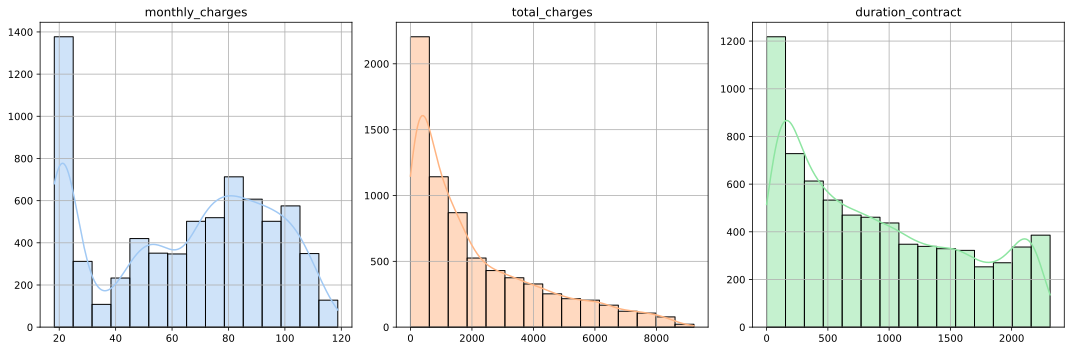

In [54]:
features = ['monthly_charges', 'total_charges', 'duration_contract']
plot_hist(contract_new, features, bins=15)

По представленным гистограммам можно сделать следующие выводы:

1.	Monthly_charges (Ежемесячные платежи):

*	Распределение ежемесячных платежей имеет два пика, что может указывать на наличие двух различных групп пользователей или тарифных планов.
*	Большинство платежей приходится на диапазон от 20 до около 30 единиц, что, вероятно, является самым дешевым предложением.
*	Второй пик около 80 единиц может указывать на наличие более дорогого тарифного плана или дополнительных услуг.
*	Распределение ежемесячных платежей не является нормальным и имеет скос вправо, то есть больше клиентов с низкими ежемесячными платежами.

2.	Total_charges (Общая сумма платежей):
   
*	Распределение общей суммы платежей показывает экспоненциальное убывание, что может свидетельствовать о том, что большинство клиентов имеют относительно короткий период пользования услугами или низкие ежемесячные платежи.
*	Есть значительное количество людей с очень низкими общими платежами, возможно, новые пользователи или те, кто отказался от услуг после короткого использования.
*	Мало клиентов с очень высокими общими платежами, что может указывать на то, что долгосрочные клиенты или клиенты с высокими ежемесячными платежами являются редкостью.

3.	Duration_contract (Длительность контракта):

*	Большинство контрактов сосредоточены в нижнем диапазоне, что предполагает, что у большинства клиентов короткие контракты.
*	Похоже, что есть снижение числа клиентов с увеличением длительности контракта, что может указывать на то, что клиенты со временем имеют тенденцию уходить или переходить на другие услуги.
*	Возможно, присутствует некоторый циклический паттерн с небольшими всплесками в определенных точках, что может указывать на стандартные длительности контрактов (например, годовые или полугодовые).



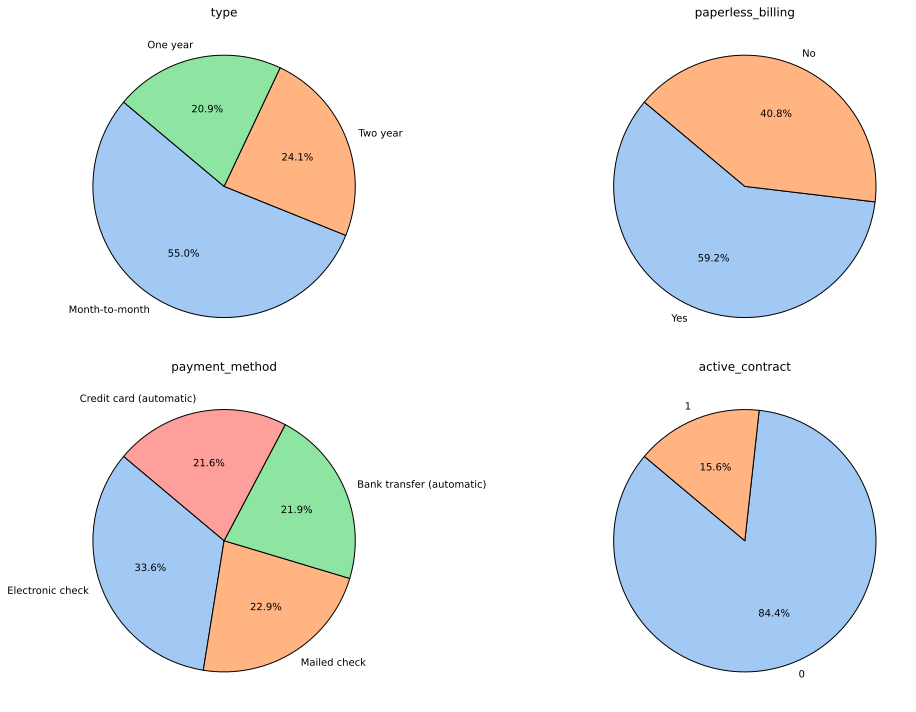

In [77]:
features = ['type', 'paperless_billing', 'payment_method', 'active_contract']
plot_pie_charts(contract_new, features, [2, 2])

На основе круговых диаграмм можно сделать следующие краткие выводы:

1.	Тип контракта (type)
 :
*	Большинство клиентов (55%) используют контракты с ежемесячной оплатой.
*	Контракты сроком на один год составляют около 20.9%.
*	Контракты сроком на два года занимают 24.
1%.
2.	Безбумажный биллинг (paperless_bill
 	ing):
*	Больше клиентов (59.2%) предпочитают безбумажный биллинг, в то время как 40.8% не используют эту
  опцию.
3.	Способ оплаты (payment_m
   ethod):
*	Наиболее распространённый способ оплаты – электронный чек (33.6%).
*	Остальные способы оплаты распределены более равномерно: кредитной картой (автоматически) – 21.6%, банковским переводом (автоматически) – 21.9%, чеком, отправленным по почте
– 22.9%.
4.	Активность контракта (active_
   contract):
*	Большая часть контрактов (84.4%) в данный момент неактивны.
*	15.6% контрактов являются активными.


### Анализ и предобработка `personal_new` (персональные данные клиента)

In [26]:
# Анализ датафрейма "personal_new"
show_data(personal_new, RANDOM_STATE)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

,customerID,gender,SeniorCitizen,Partner,Dependents
4451,1608-GMEWB,Male,1,No,No
6957,3914-FDRHP,Male,0,No,No
5249,5115-GZDEL,Male,0,No,Yes
2727,3387-VATUS,Male,0,No,No
646,0887-HJGAR,Male,0,No,No


In [27]:
# Подсчет уникальных значений для всех столбцов
get_unique_counts(personal_new)

Количество уникальных значений для каждого столбца:
customerID       7043
gender              2
SeniorCitizen       2
Partner             2
Dependents          2


**Предварительные выводы**

1. Датафрейм `personal_new` содержит 5 признаков и 7043 объекта.
1. Датафрейм не содержит пропусков.
1. Признак `customerID` содерижт идентификаторы клиентов.
1. Признаки `gender`, `SeniorCitizen`, `Partner` и `Dependents` бинарные категориальные. Их требуется трансформировать методом `OneHotEncoder` (для "линейных" моделей) и `OrdinalEncoder` (для "деревянных" моделей) в `Pipeline` перед обучением модели.
1. Признак `SeniorCitizen` отличается от других категориальных бинарных признаков наличием числовых значений. Для его унификации с другими категориальными значениями требуется его значения `0` и `1` привести к `No` и `Yes` соответственно, а тип данных `SeniorCitizen` привести к типу `object`.
1. Названия признаков желательно привести к "змеиному стилю".

In [78]:
# Трансформация категориальных признаков, кроме "SeniorCitizen"
personal_new['SeniorCitizen'] = personal_new['SeniorCitizen'].map({0: 'No', 1: 'Yes'})

In [79]:
# Приведение названий признаков датафрейма к "змеиному стилю"
personal_new = preprocess_column_names(personal_new)

# Проверка полученных названий
personal_new.columns

Index(['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents'], dtype='object')

In [80]:
# Анализ датафрейма после предобработки данных
show_data(personal_new, RANDOM_STATE)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_citizen  7043 non-null   object
 3   partner         7043 non-null   object
 4   dependents      7043 non-null   object
dtypes: object(5)
memory usage: 275.2+ KB


None

,customer_id,gender,senior_citizen,partner,dependents
4451,1608-GMEWB,Male,Yes,No,No
6957,3914-FDRHP,Male,No,No,No
5249,5115-GZDEL,Male,No,No,Yes
2727,3387-VATUS,Male,No,No,No
646,0887-HJGAR,Male,No,No,No


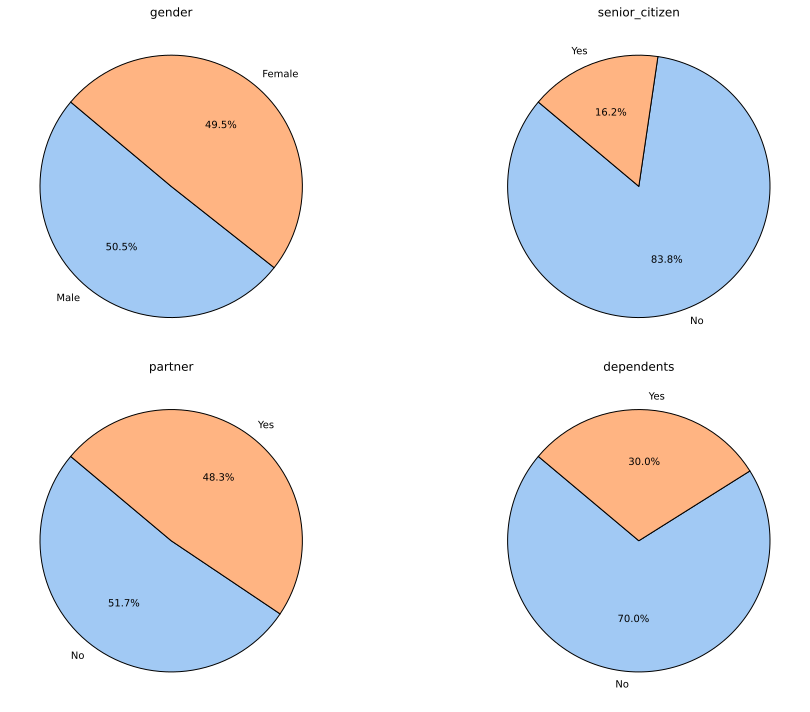

In [82]:
features = ['gender', 'senior_citizen', 'partner', 'dependents']
plot_pie_charts(personal_new, features, [2, 2])


На основании этих круговых диаграмм можно сделать следующие выводы о персональных данных клиентов:

1.	Пол (gender):
   
*	Соотношение мужчин и женщин среди клиентов практически равное: 50.5% мужчин и 49.5% женщин.

2.	Пожилые граждане (senior_citizen):

*	Большинство клиентов (83.8%) не являются пожилыми гражданами, в то время как 16.2% относятся к пожилому возрасту.

3.	Наличие партнёра (partner):

*	Клиенты почти поровну разделены на тех, у кого есть партнёры (51.7%), и тех, у кого их нет (48.3%).

4.	Иждивенцы (dependents):

*	Большинство клиентов (70%) не имеют иждивенцев, тогда как 30% клиентов имеют иждивенцев.



### Анализ и предобработка `internet_new` (информация об интернет-услугах)

In [32]:
# Анализ датафрейма "internet_new"
show_data(internet_new, RANDOM_STATE)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1658,3106-ULWFW,Fiber optic,No,No,No,No,No,Yes
2321,6898-MDLZW,DSL,No,Yes,No,Yes,No,No
2118,0254-KCJGT,DSL,Yes,Yes,Yes,Yes,No,Yes
2768,1530-ZTDOZ,DSL,Yes,No,No,No,Yes,No
1435,3536-IQCTX,Fiber optic,No,No,No,No,No,Yes


In [33]:
get_unique_counts(internet_new)

Количество уникальных значений для каждого столбца:
customerID          5517
InternetService        2
OnlineSecurity         2
OnlineBackup           2
DeviceProtection       2
TechSupport            2
StreamingTV            2
StreamingMovies        2


**Предварительные выводы:**

1.	Датафрейм internet_new состоит из 8 признаков и содержит информацию о 5517 объектах.
2.	В данных отсутствуют пропущенные значения, что облегчает их анализ и обработку.
3.	Признак customerID используется для идентификации клиентов в датафрейме.
4.	Признаки InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV и StreamingMovies являются бинарными категориальными. Для подготовки данных к обучению модели необходимо применить кодирование методами OneHotEncoder для линейных моделей и OrdinalEncoder для деревянных моделей в Pipeline.
5.	Рекомендуется привести названия признаков к формату "змеиного стиля" для улучшения читаемости кода и согласованнсти.


In [83]:
# Приведение названий признаков датафрейма к "змеиному стилю"
internet_new = preprocess_column_names(internet_new)

# Проверка полученных названий
internet_new.columns

Index(['customer_id', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies'],
      dtype='object')

In [84]:
# Анализ датафрейма после предобработки данных
show_data(internet_new, RANDOM_STATE)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        5517 non-null   object
 1   internet_service   5517 non-null   object
 2   online_security    5517 non-null   object
 3   online_backup      5517 non-null   object
 4   device_protection  5517 non-null   object
 5   tech_support       5517 non-null   object
 6   streaming_tv       5517 non-null   object
 7   streaming_movies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
1658,3106-ULWFW,Fiber optic,No,No,No,No,No,Yes
2321,6898-MDLZW,DSL,No,Yes,No,Yes,No,No
2118,0254-KCJGT,DSL,Yes,Yes,Yes,Yes,No,Yes
2768,1530-ZTDOZ,DSL,Yes,No,No,No,Yes,No
1435,3536-IQCTX,Fiber optic,No,No,No,No,No,Yes


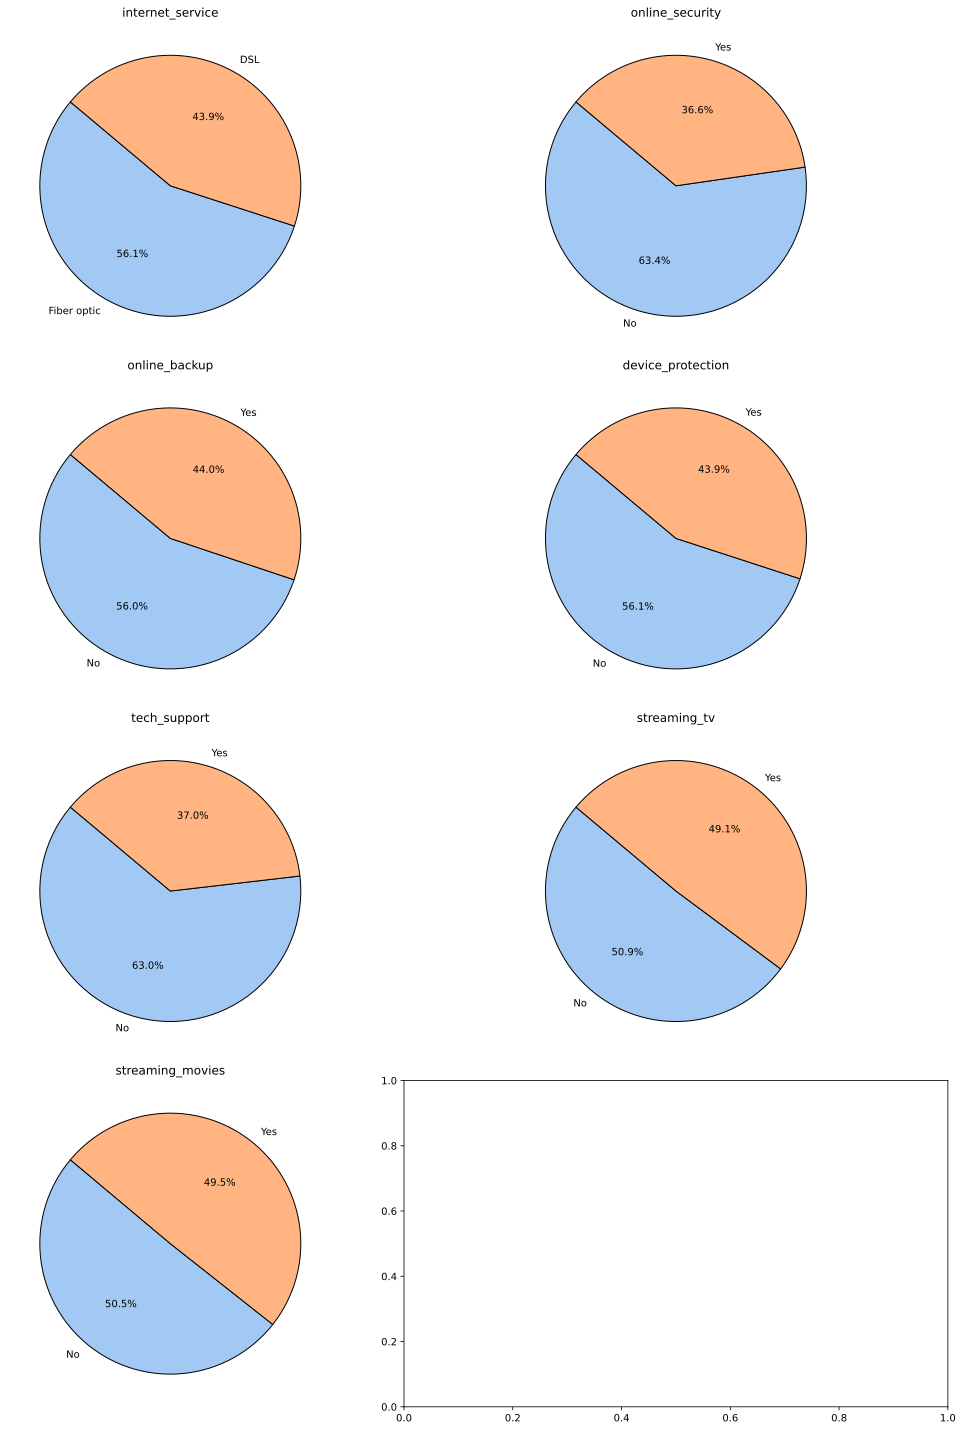

In [86]:
features = ['internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']
plot_pie_charts(internet_new, features, [4, 2])


Из круговых диаграмм, которые касаются информации об интернет-услугах клиентов, можно сделать следующие выводы:

1.	Интернет-сервис (internet_service):

*	Большинство клиентов (56.1%) используют оптоволоконный интернет.
*	DSL интернет используется 43.9% клиентов.
  
2.	Онлайн-безопасность (online_security):

*	Большая часть клиентов (63.4%) не используют услуги онлайн-безопасности.
*	36.6% клиентов подключили услугу онлайн-безопасности.

3.	Онлайн-бэкап (online_backup):

*	56% клиентов не используют услуги онлайн-бэкапа.
*	44% клиентов пользуются услугами онлайн-бэкапа.

4.	Защита устройства (device_protection):

*	56.1% клиентов не используют услуги по защите устройства.
*	43.9% клиентов используют защиту устройства.

5.	Техподдержка (tech_support):

*	Большинство клиентов (63%) не используют услуги технической поддержки.
*	37% клиентов используют услуги технической поддержки.

6.	Стриминговое ТВ (streaming_tv):
*	Клиенты почти поровну разделены в своем предпочтении использования стримингового ТВ: 50.9% не используют стриминговое ТВ, в то время как 49.1% используют.



### Анализ и предобработка `phone_new` (информация об услугах телефонии)

In [37]:
# Анализ датафрейма "phone_new"
show_data(phone_new, RANDOM_STATE)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

,customerID,MultipleLines
3704,6199-IPCAO,Yes
5137,1121-QSIVB,Yes
3309,0512-FLFDW,Yes
591,1140-UKVZG,Yes
3786,7858-GTZSP,Yes


In [38]:
get_unique_counts(phone_new)

Количество уникальных значений для каждого столбца:
customerID       6361
MultipleLines       2


**Предварительные выводы**

1. Датафрейм `phone_new` содержит 2 признака и 6361 объект.
1. Датафрейм не содержит пропусков.
1. Признак `customerID` содерижт идентификаторы клиентов.
1. Признак `MultipleLines` бинарный категориальный. Его требуется трансформировать методом `OneHotEncoder` (для "линейных" моделей) и `OrdinalEncoder` (для "деревянных" моделей) в `Pipeline` перед трансформировать моделей.
1. Названия признаков желательно привести к "змеиному стилю".

In [87]:
# Приведение названий признаков датафрейма к "змеиному стилю"
phone_new = preprocess_column_names(phone_new)

# Проверка полученных названий
phone_new.columns

Index(['customer_id', 'multiple_lines'], dtype='object')

In [88]:
# Проверка датафрейма после изменения
show_data(phone_new, RANDOM_STATE)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     6361 non-null   object
 1   multiple_lines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

,customer_id,multiple_lines
3704,6199-IPCAO,Yes
5137,1121-QSIVB,Yes
3309,0512-FLFDW,Yes
591,1140-UKVZG,Yes
3786,7858-GTZSP,Yes


## Объединение данных

Объединение выбранных признаков в один датафрейм по ключу. Ключом является признак `customer_id` (идентификатор клиента) во всех датафреймах.

In [89]:
# Проверка баланса классов
def check_class_balance(target, name):
    balance = target.value_counts(normalize=True)
    print(f'Классы в {name} выборке сбалансированы.' if balance[0] == balance[1] else f'Классы в {name} выборке не сбалансированы.')
    print(f'Класс 0: {(balance[0] * 100).round(2)}%')
    print(f'Класс 1: {(balance[1] * 100).round(2)}%')

In [90]:
print('Размерность датафрейма "contract_new":', contract_new.shape)
print('Размерность датафрейма "personal_new":', personal_new.shape)
print('Размерность датафрейма "internet_new":', internet_new.shape)
print('Размерность датафрейма "phone_new"   :', phone_new.shape)

Размерность датафрейма "contract_new": (7043, 8)
Размерность датафрейма "personal_new": (7043, 5)
Размерность датафрейма "internet_new": (5517, 8)
Размерность датафрейма "phone_new"   : (6361, 2)


In [91]:
personal_new['customer_id'].equals(contract_new['customer_id'])

True

In [117]:
# Последовательное объединение датафреймов в "total_new"
total_new = personal_new.join(contract_new.set_index('customer_id'), on='customer_id')
total_new = total_new.join(internet_new.set_index('customer_id'), on='customer_id', how='left')
total_new = total_new.join(phone_new.set_index('customer_id'), on='customer_id', how='left')

## Исследовательский анализ данных объединённого датафрейма

Выполнение исследовательского анализа объединённого датафрейма, визуализация распределения признаков и при необходимости выполнение предобработки. Корреляционный анализ.

In [101]:
# Функция для анализа данных и построения гистограммы
def analyze_and_plot(column, df, hue, a=0.4):
    plt.figure(figsize=(10, 6))
    sns.histplot(df[column][df['active_contract'] == 0], color='blue', alpha=a, label='Класс 0')
    sns.histplot(df[column][df['active_contract'] == 1], color='red', alpha=a, label='Класс 1')
    plt.title(f'Распределение "{column}"')
    plt.xlabel(f'"{column}"')
    plt.ylabel('Количество')
    plt.legend(title='active_contract', labels=['Класс 0', 'Класс 1'])
    plt.show()

### Исследовательский анализ объединённого датафрейма

In [118]:
# Анализ объединенного датафрейма
total_new.info()
total_new.sample(n=5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   gender             7043 non-null   object 
 2   senior_citizen     7043 non-null   object 
 3   partner            7043 non-null   object 
 4   dependents         7043 non-null   object 
 5   type               7043 non-null   object 
 6   paperless_billing  7043 non-null   object 
 7   payment_method     7043 non-null   object 
 8   monthly_charges    7043 non-null   float64
 9   total_charges      7043 non-null   float64
 10  active_contract    7043 non-null   int64  
 11  duration_contract  7043 non-null   int64  
 12  internet_service   5517 non-null   object 
 13  online_security    5517 non-null   object 
 14  online_backup      5517 non-null   object 
 15  device_protection  5517 non-null   object 
 16  tech_support       5517 

,customer_id,gender,senior_citizen,partner,dependents,type,paperless_billing,payment_method,monthly_charges,total_charges,active_contract,duration_contract,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
2349,9548-ZMVTX,Male,No,Yes,Yes,Two year,No,Bank transfer (automatic),90.45,6512.40,0,2191,Fiber optic,No,Yes,Yes,Yes,No,No,Yes
3485,6221-AVQYL,Male,No,No,No,Month-to-month,Yes,Credit card (automatic),73.25,219.75,0,92,Fiber optic,No,No,No,No,No,No,Yes
5968,9033-EOXWV,Female,No,No,No,One year,No,Mailed check,74.05,807.15,1,304,DSL,No,No,No,Yes,Yes,Yes,Yes
2637,7665-NKLAV,Female,No,Yes,Yes,Two year,No,Credit card (automatic),40.65,1565.84,0,1095,DSL,Yes,No,Yes,Yes,No,No,NaN
4053,7446-YPODE,Male,Yes,No,No,Month-to-month,No,Bank transfer (automatic),60.25,709.14,0,337,DSL,Yes,Yes,No,No,No,No,Yes


Учитывая, что мы будем использовать линейную регрессию, необходимо предобработать данные, заменив NaN на NoValue, в дальнейшем будем их кодировать

In [111]:
# "NaN" - это не приобретенные значения
total_new = total_new.fillna('NoValue')

In [112]:
# Справочник признаков объединенного датафрейма
total_new_features = {
    'customer_id':'идентификатор абонента',
    'gender':'пол',
    'senior_citizen':'является ли абонент пенсионером',
    'partner':'есть ли у абонента супруг или супруга',
    'dependents':'есть ли у абонента дети',

    'type':'тип оплаты',
    'paperless_billing':'электронный расчётный лист',
    'payment_method':'тип платежа',
    'monthly_charges':'расходы за месяц',
    'total_charges':'общие расходы абонента',
    'active_contract':'активный договор (целевой признак)',
    'duration_contract':'продолжительность договора в днях',

    'internet_service':'тип подключения',
    'online_security':'блокировка опасных сайтов',
    'online_backup':'облачное хранилище файлов для резервного копирования данных',
    'device_protection':'антивирус',
    'tech_support':'выделенная линия технической поддержки',
    'streaming_tv':'стриминговое телевидение',
    'streaming_movies':'каталог фильмов',

    'multiple_lines':'подключение телефона к нескольким линиям одновременно'
}

In [113]:
# Проверка справочника признаков
total_new_features

{'customer_id': 'идентификатор абонента',
 'gender': 'пол',
 'senior_citizen': 'является ли абонент пенсионером',
 'partner': 'есть ли у абонента супруг или супруга',
 'dependents': 'есть ли у абонента дети',
 'type': 'тип оплаты',
 'paperless_billing': 'электронный расчётный лист',
 'payment_method': 'тип платежа',
 'monthly_charges': 'расходы за месяц',
 'total_charges': 'общие расходы абонента',
 'active_contract': 'активный договор (целевой признак)',
 'duration_contract': 'продолжительность договора в днях',
 'internet_service': 'тип подключения',
 'online_security': 'блокировка опасных сайтов',
 'online_backup': 'облачное хранилище файлов для резервного копирования данных',
 'device_protection': 'антивирус',
 'tech_support': 'выделенная линия технической поддержки',
 'streaming_tv': 'стриминговое телевидение',
 'streaming_movies': 'каталог фильмов',
 'multiple_lines': 'подключение телефона к нескольким линиям одновременно'}

Распределение "gender":


,count,unique,top,freq
gender,5942,2,Male,2982
gender,1101,2,Male,573


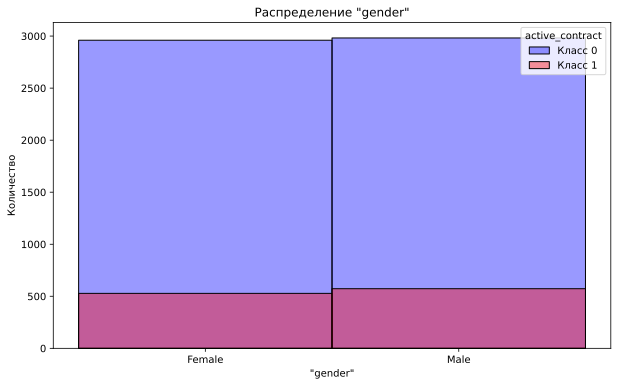

Распределение "senior_citizen":


,count,unique,top,freq
senior_citizen,5942,2,No,5032
senior_citizen,1101,2,No,869


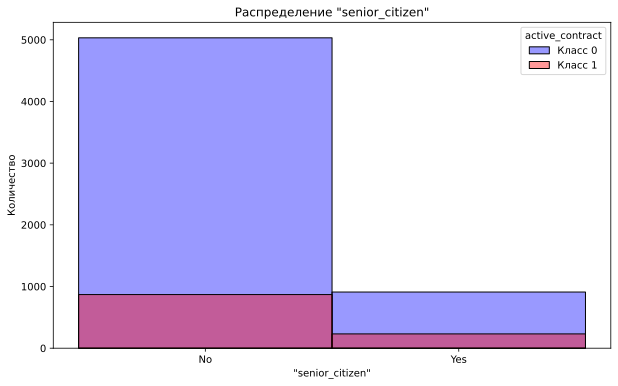

Распределение "partner":


,count,unique,top,freq
partner,5942,2,No,3259
partner,1101,2,Yes,719


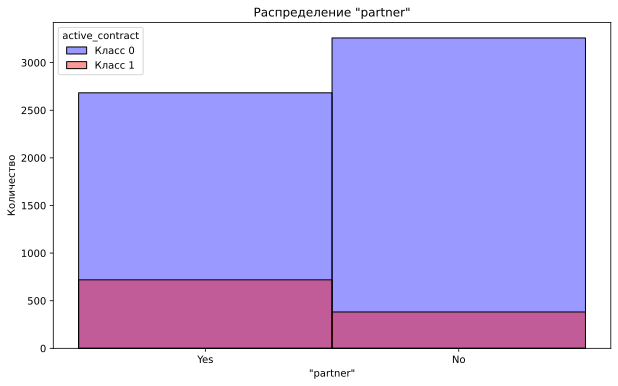

Распределение "dependents":


,count,unique,top,freq
dependents,5942,2,No,4200
dependents,1101,2,No,733


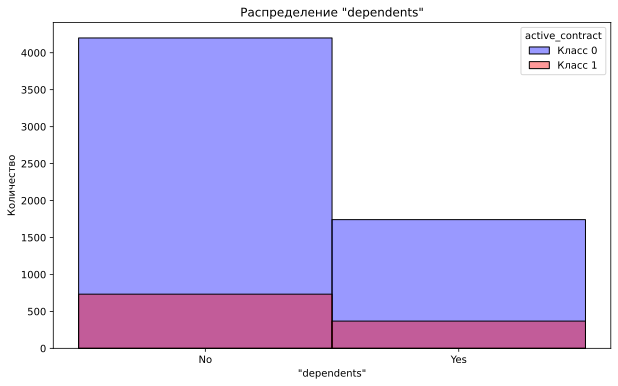

Распределение "type":


,count,unique,top,freq
type,5942,3,Month-to-month,3468
type,1101,3,Month-to-month,407


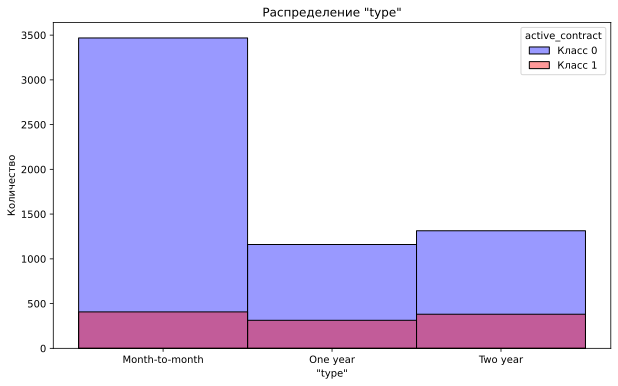

Распределение "paperless_billing":


,count,unique,top,freq
paperless_billing,5942,2,Yes,3450
paperless_billing,1101,2,Yes,721


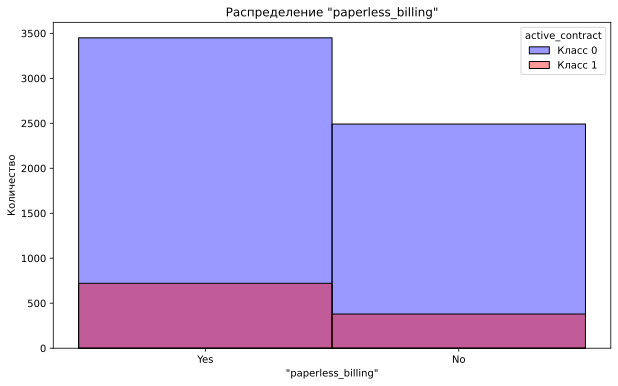

Распределение "payment_method":


,count,unique,top,freq
payment_method,5942,4,Electronic check,2015
payment_method,1101,4,Electronic check,350


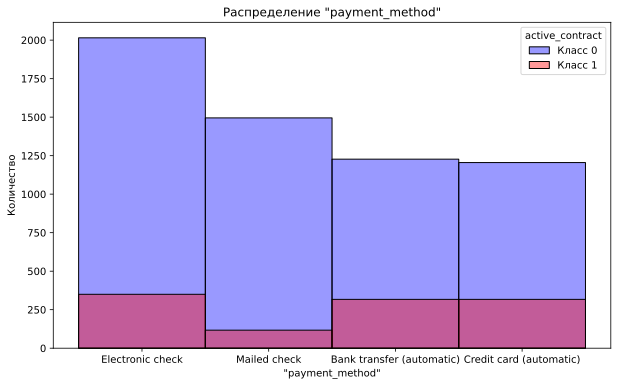

Распределение "monthly_charges":


,count,mean,std,min,25%,50%,75%,max
monthly_charges,5942.0,62.763455,29.844462,18.25,30.0625,69.2,87.2375,118.60
monthly_charges,1101.0,75.546004,29.116213,18.40,56.1500,84.2,99.5000,118.75


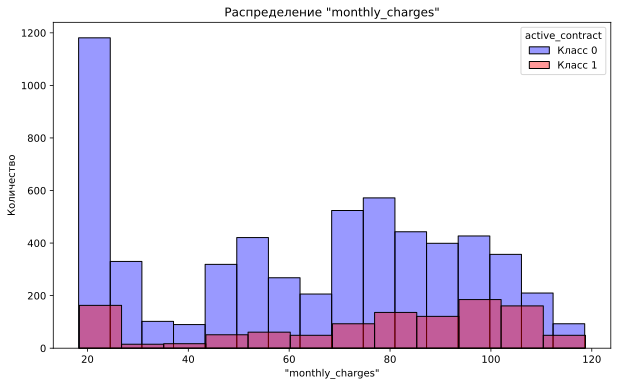

Распределение "total_charges":


,count,mean,std,min,25%,50%,75%,max
total_charges,5942.0,2067.866420,2193.898483,0.00,374.3525,1192.80,3173.8375,9221.38
total_charges,1101.0,2371.377275,1581.862275,77.84,1048.0500,2139.03,3404.9100,7649.76


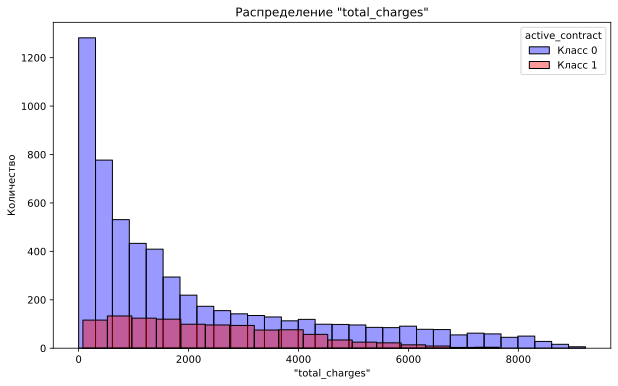

Распределение "active_contract":


,count,mean,std,min,25%,50%,75%,max
active_contract,5942.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
active_contract,1101.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0


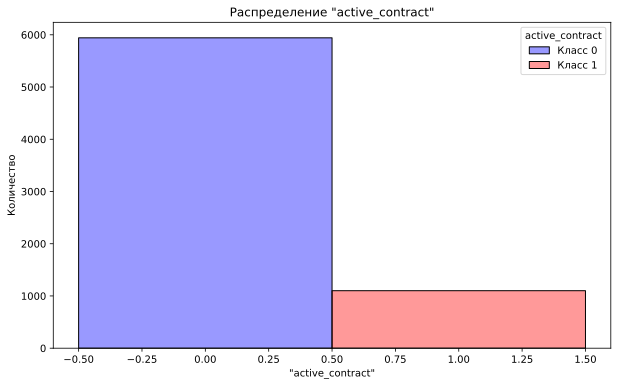

Распределение "duration_contract":


,count,mean,std,min,25%,50%,75%,max
duration_contract,5942.0,893.681084,716.958551,0.0,245.0,702.0,1523.0,2314.0
duration_contract,1101.0,924.863760,458.771309,28.0,577.0,915.0,1249.0,2129.0


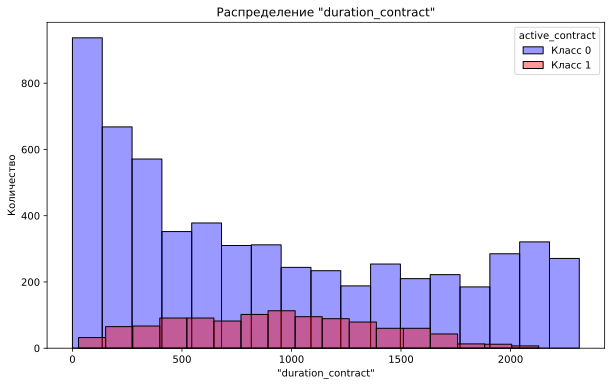

Распределение "internet_service":


,count,unique,top,freq
internet_service,5942,3,Fiber optic,2501
internet_service,1101,3,Fiber optic,595


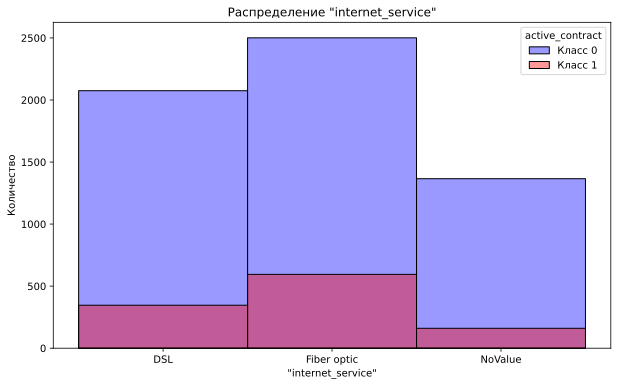

Распределение "online_security":


,count,unique,top,freq
online_security,5942,3,No,2972
online_security,1101,3,No,526


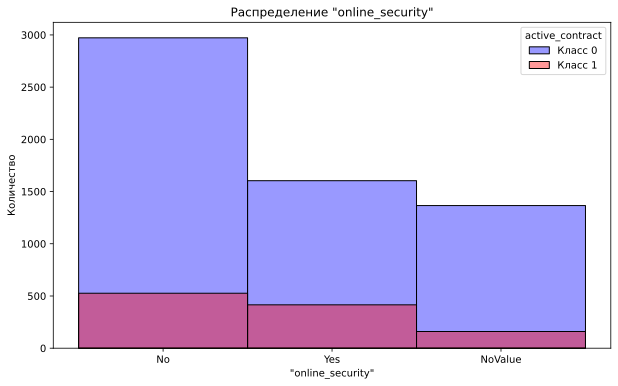

Распределение "online_backup":


,count,unique,top,freq
online_backup,5942,3,No,2707
online_backup,1101,3,Yes,560


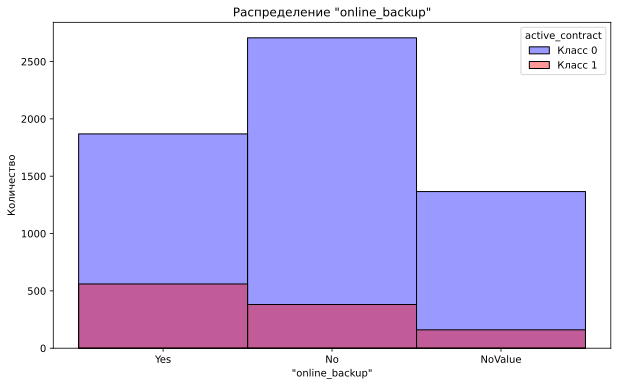

Распределение "device_protection":


,count,unique,top,freq
device_protection,5942,3,No,2704
device_protection,1101,3,Yes,550


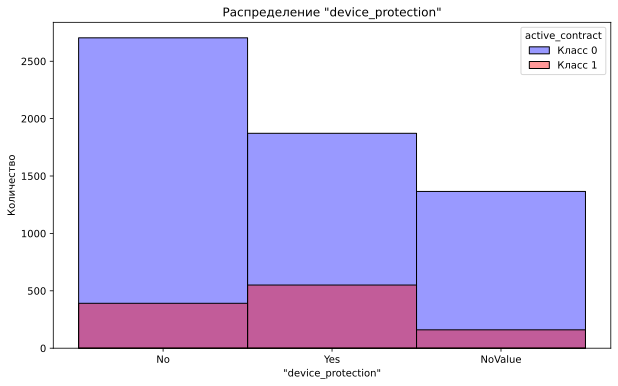

Распределение "tech_support":


,count,unique,top,freq
tech_support,5942,3,No,2930
tech_support,1101,3,No,543


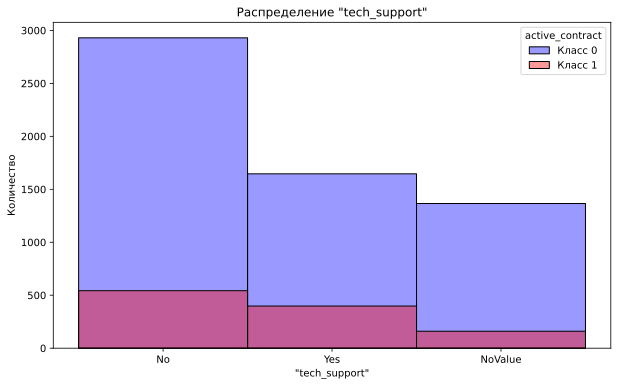

Распределение "streaming_tv":


,count,unique,top,freq
streaming_tv,5942,3,No,2453
streaming_tv,1101,3,Yes,584


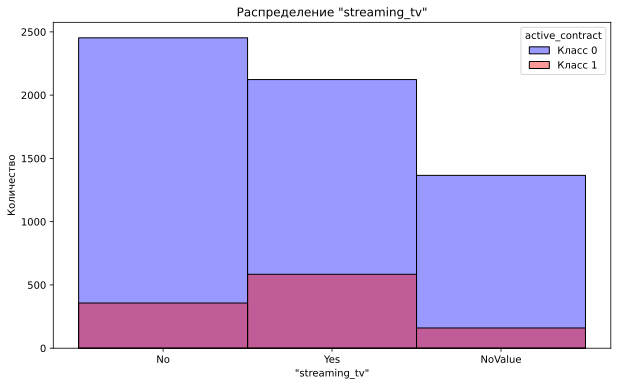

Распределение "streaming_movies":


,count,unique,top,freq
streaming_movies,5942,3,No,2450
streaming_movies,1101,3,Yes,606


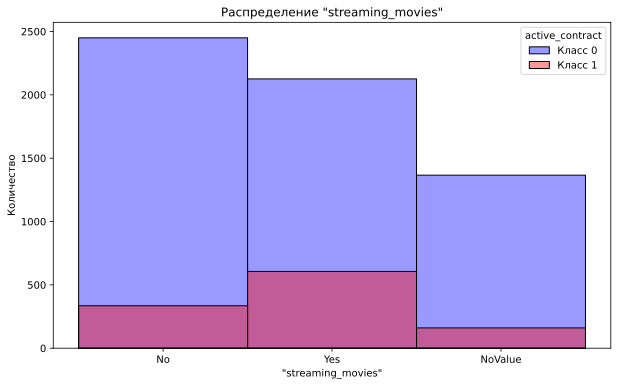

Распределение "multiple_lines":


,count,unique,top,freq
multiple_lines,5942,3,No,3070
multiple_lines,1101,3,Yes,678


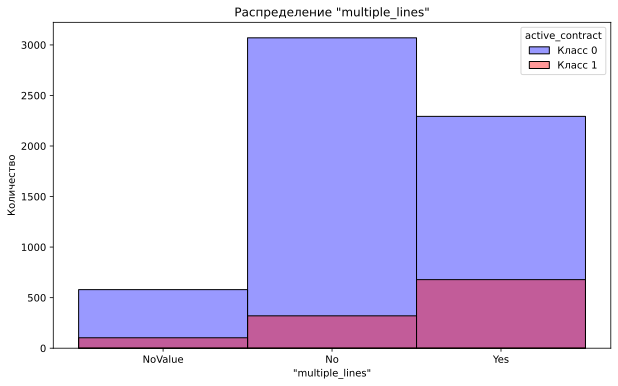

In [114]:
# Анализ данных и построение гистограммы для всех признаков
for column in total_new.columns:
    if column != 'customer_id':
        print(f'Распределение "{column}":')
        display(pd.DataFrame([total_new[column][total_new['active_contract'] == 0].describe(),
                              total_new[column][total_new['active_contract'] == 1].describe()]))
        analyze_and_plot(column, total_new, 'active_contract')

На основе представленных гистограмм можно сделать следующие краткие выводы о клиентах:

1.	По полу (gender):

*	Среди мужчин и женщин примерно равное количество тех, кто не имеет активного контракта (класс 0).
*	Небольшое количество мужчин и женщин имеют активные контракты (класс 1).

2.	По пожилым гражданам (senior_citizen):

*	Большая часть пожилых граждан не имеет активного контракта.
*	Среди не пожилых граждан также большинство не имеют активного контракта, но их доля активных контрактов выше по сравнению с пожилыми.

3.	По наличию партнёра (partner):

*	Люди без партнёра чаще не имеют активного контракта, нежели те, у кого партнёр есть.
*	Среди тех, у кого есть партнёры, примерно равное количество клиентов с активными и неактивными контрактами.

4.	По наличию иждивенцев (dependents):

*	Большая часть клиентов без иждивенцев не имеют активного контракта.
*	Среди клиентов с иждивенцами больше тех, кто имеет активный контракт, по сравнению с теми, у кого его нет.

5.	По типу контракта (type):

*	Большинство клиентов с месячной оплатой не имеют активного контракта.
*	Среди клиентов с годовыми и двухгодовыми контрактами количество неактивных контрактов также преобладает, но доля активных контрактов выше, чем среди клиентов с месячной оплатой.

6.	По использованию безбумажного биллинга (paperless_billing):

*	Больше клиентов, использующих безбумажный биллинг, не имеют активного контракта.
*	Среди тех, кто не использует безбумажный биллинг, также большинство клиентов не имеют активного контракта.

7.	По способу оплаты (payment_method):

*	Клиенты, использующие электронный чек, чаще всего не имеют активного контракта.
*	Среди клиентов, использующих другие методы оплаты (чеки по почте, автоматические банковские переводы, автоматические платежи кредитной картой), также преобладают неактивные контракты, однако доля активных контрактов среди них выше, чем у пользователей электронных чеков.

8.	Monthly_charges:

*	Большинство клиентов без активного контракта имеют низкие ежемесячные платежи.
*	С увеличением ежемесячного платежа доля клиентов с активным контрактом растёт.

9.	Total_charges:

*	Клиенты с более высоким общим объёмом платежей имеют тенденцию иметь активный контракт.
*	Клиенты с низкими общими платежами часто не имеют активного контракта.

10.	Duration_contract:

*	Существует большое количество клиентов с коротким сроком контракта без активного контракта.
*	С увеличением продолжительности контракта увеличивается и доля активных контрактов.

11.	Internet_service:

*	Оптоволоконный интернет чаще используется клиентами с активным контрактом.
*	DSL чаще встречается у клиентов без активного контракта.

12.	Online_security:

*	Услуги онлайн-безопасности популярны среди клиентов с активным контрактом.
*	Большинство клиентов без услуг онлайн-безопасности не имеют активного контракта.

13.	Online_backup:

*	Услуги онлайн-бэкапа чаще активны у клиентов с активным контрактом.
*	Клиенты без онлайн-бэкапа часто не имеют активного контракта.

14.	Device_protection:

*	Защита устройства также является популярной услугой среди клиентов с активными контрактами.
*	Большая часть клиентов без этой услуги не имеет активного контракта.

15.	Tech_support:

*	Техническая поддержка востребована среди клиентов с активными контрактами.
*	Большое количество клиентов без технической поддержки не имеют активного контракта.

16.	Streaming_tv и Streaming_movies:

*	Стриминговые услуги (телевидение и фильмы) популярны среди клиентов с активным контрактом.
*	Клиенты без стриминговых услуг чаще всего не имеют активного контракта.




In [115]:
# Фильтрация числовых и категориальных признаков для нормализации и кодирования
total_new_numeric = ['monthly_charges', 'total_charges', 'duration_contract']
total_new_categories = [col for col in total_new.columns
                        if col not in total_new_numeric and col not in ['customer_id', 'active_contract']]

np.random.seed(RANDOM_STATE)
print(f'Числовые признаки, требующие нормализации: {len(total_new_numeric)}')
display(total_new[total_new_numeric].head())

print(f'\nКатегориальные признаки, требующие кодирования: {len(total_new_categories)}')
display(total_new[total_new_categories].head().T)

Числовые признаки, требующие нормализации: 3


,monthly_charges,total_charges,duration_contract
0,29.85,31.04,31
1,56.95,2071.84,1036
2,53.85,226.17,123
3,42.30,1960.60,1371
4,70.70,353.50,153



Категориальные признаки, требующие кодирования: 15


,0,1,2,3,4
gender,Female,Male,Male,Male,Female
senior_citizen,No,No,No,No,No
partner,Yes,No,No,No,No
dependents,No,No,No,No,No
type,Month-to-month,One year,Month-to-month,One year,Month-to-month
paperless_billing,Yes,No,Yes,No,Yes
payment_method,Electronic check,Mailed check,Mailed check,Bank transfer (automatic),Electronic check
internet_service,DSL,DSL,DSL,DSL,Fiber optic
online_security,No,Yes,Yes,Yes,No
online_backup,Yes,No,Yes,No,No


**Предварительные выводы**

1. Выборка `total_new` содержит 20 признаков и 7043 объекта.
1. В объединенном датафрейме имеются 3 категориальных и 27 числовых признака. Часть из них не сбалансированы. Категориальные имеют дисбаланс классов, а числовые не не имеют нормального распределения или имеют существенное количество выбросов.
1. Признак `active_contract` является целевым для обучения. Он бинарный категориальный и не сбалансирован с перевесом в пользу значения `1` (контракт активен). Данный признак не содержит пропусков. Следовательно, по всем объектам выборки есть целевые значения.
1. Многие категориальные признаки содержат пропуски. Эти пропуски не требуется обрабатывать, т.к. не известны причины их появления.
1. Все категориальные признаки, в том числе те, что ранее содержали только `0` и `1`, но кроме целевого, требуется кодировать методом `OneHotEncoder` (для "линейных" моделей) и `OrdinalEncoder` (для "деревянных" моделей).
1. Все числовые признаки, названия которых входят в переменную `total_new_numeric` (`monthly_charges`, `total_charges`, `duration_contract`), требуется нормализовать.
1. Все признаки требуется проверить на наличие корреляции. Сильно выраженные мультиколленеарные признаки и признаки со статистически не значемой корреляцией требуется исключить из объединенного датафрейма при обучении моделей.

### Анализ мультиколлинеарности

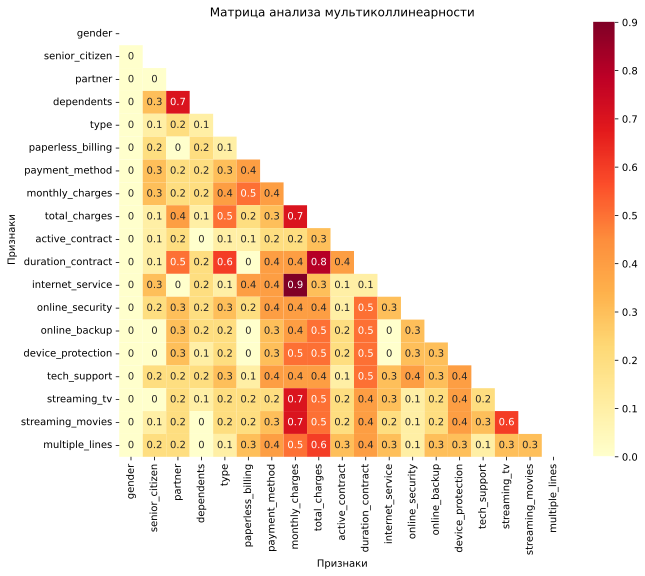

In [105]:
# Анализ мультиколлинеарности с помощью методов библиотеки Phik
multicollinearity = total_new.drop('customer_id', axis=1).phik_matrix(interval_cols=total_new_numeric)

# Создание маски для верхнего треугольника
mask = np.triu(np.ones_like(multicollinearity, dtype=bool))

# Построение тепловой карты с подписями
plt.figure(figsize=(10, 8))
sns.heatmap(multicollinearity.round(1), annot=True, cmap='YlOrRd', mask=mask)
plt.title('Матрица анализа мультиколлинеарности')
plt.xlabel('Признаки')
plt.ylabel('Признаки')
plt.show()

На основе представленной матрицы анализа мультиколлинеарности (где значения близкие к 1 указывают на сильную корреляцию между признаками), можно сделать следующие выводы об абонентах оператора связи:

1.	Сильная положительная корреляция между dependents и partner, что может указывать на то, что абоненты с партнёрами часто имеют иждивенцев.
2.	Device_protection, tech_support, online_backup, online_security, streaming_tv и streaming_movies имеют сильную взаимосвязь друг с другом. Это указывает на то, что абоненты, которые подписаны на одну из этих услуг, скорее всего, будут подписаны и на другие.
3.	Высокая корреляция между monthly_charges и total_charges говорит о том, что абоненты с высокими ежемесячными платежами, как правило, накапливают и высокие общие платежи со временем.
4.	Заметна корреляция между duration_contract и total_charges, подразумевая, что более длительные контракты соответствуют большим общим платежам, возможно, из-за более длительного времени пользования услугами.
5.	Наличие активного контракта (active_contract) не показывает высокой корреляции ни с одним из других признаков, что может свидетельствовать о том, что решение абонентов об отказе или продолжении контракта зависит от комплекса факторов, а не от какого-то одного условия.



### Отбор признаков для использования в обучении моделей

В обучающую и тестовую выборки должны попасть только признаки, относительно высокойкорелируемые с целевым признаком. Из мультиколлинеарных признаков требуется оставить в выборках только те, что имеют большую корреляцию с целевым признаком.

Предлагается установить минимальный порог коррелируемости с целевым признаком в 0.3. Также предлагается установить максимальный порог мультиколлинеарности в 0.9.

In [106]:
def non_multicollinear_features(m, target_feature, v_min, v_max):
    columns = []

    for c in m.columns:
        if (c != target_feature) and (m[c][target_feature] > v_min):
            append = all((m[c][i] <= v_max) or (m[c][target_feature] >= m[i][target_feature]) for i in m.index if (c != i) and (c not in columns) and (i not in columns))
            if append:
                columns.append(c)

    return columns

def split_features(total_new_categories, total_new_numeric, columns):
    features_categories = [i for i in columns if i in total_new_categories]
    features_numeric = [i for i in columns if i in total_new_numeric]
    return features_categories, features_numeric

In [108]:
columns = non_multicollinear_features(multicollinearity, 'active_contract', 0.03, 0.9)

print('Не мультиколлинеарные признаки с корреляцией целевого признака:')
columns

Не мультиколлинеарные признаки с корреляцией целевого признака:


['senior_citizen',
 'partner',
 'dependents',
 'type',
 'paperless_billing',
 'payment_method',
 'monthly_charges',
 'total_charges',
 'duration_contract',
 'internet_service',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'multiple_lines']

In [119]:
# Разделение отобранных параметров на категориальные и числовые
features_categories, features_numeric = split_features(total_new_categories, total_new_numeric, columns)

print(f'Категориальные признаки: {features_categories}')
print(f'Числовые признаки {features_numeric}:')

Категориальные признаки: ['senior_citizen', 'partner', 'dependents', 'type', 'paperless_billing', 'payment_method', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines']
Числовые признаки ['monthly_charges', 'total_charges', 'duration_contract']:


## Подготовка данных




In [120]:
features = total_new.drop('active_contract', axis=1)
target = total_new['active_contract']

In [121]:
# Разделение выборок 
# на обучающие и тестовые
features_train, features_test, target_train, target_test = train_test_split(
    features, 
    target, 
    test_size=TEST_SIZE, 
    stratify=target, 
    random_state=RANDOM_STATE
)

In [122]:
# Очистка выборок с фичами
# от статистически не значимых признаков
features_train = features_train[columns]
features_test = features_test[columns]

In [123]:
# Проверка выборки "features_train"
show_data(features_train, RANDOM_STATE)

<class 'pandas.core.frame.DataFrame'>
Index: 5282 entries, 2574 to 6503
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   senior_citizen     5282 non-null   object 
 1   partner            5282 non-null   object 
 2   dependents         5282 non-null   object 
 3   type               5282 non-null   object 
 4   paperless_billing  5282 non-null   object 
 5   payment_method     5282 non-null   object 
 6   monthly_charges    5282 non-null   float64
 7   total_charges      5282 non-null   float64
 8   duration_contract  5282 non-null   int64  
 9   internet_service   4158 non-null   object 
 10  online_security    4158 non-null   object 
 11  online_backup      4158 non-null   object 
 12  device_protection  4158 non-null   object 
 13  tech_support       4158 non-null   object 
 14  streaming_tv       4158 non-null   object 
 15  streaming_movies   4158 non-null   object 
 16  multiple_lines     4763 no

None

,senior_citizen,partner,dependents,type,paperless_billing,payment_method,monthly_charges,total_charges,duration_contract,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
1874,No,Yes,No,Two year,No,Credit card (automatic),86.45,3717.35,1310,DSL,Yes,Yes,No,Yes,Yes,Yes,Yes
5551,No,No,No,Month-to-month,Yes,Credit card (automatic),19.60,411.60,610,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
1998,No,Yes,No,Month-to-month,No,Electronic check,44.60,294.36,184,DSL,No,No,No,No,Yes,Yes,NaN
4211,Yes,No,No,Month-to-month,Yes,Credit card (automatic),102.95,1358.94,365,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes
4441,No,Yes,No,Two year,No,Electronic check,20.25,400.95,549,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No


In [124]:
# Проверка таргетов
show_data(target_train, RANDOM_STATE)
show_data(target_test, RANDOM_STATE)

<class 'pandas.core.series.Series'>
Index: 5282 entries, 2574 to 6503
Series name: active_contract
Non-Null Count  Dtype
--------------  -----
5282 non-null   int64
dtypes: int64(1)
memory usage: 82.5 KB


None

1874    0
5551    0
1998    0
4211    1
4441    1
Name: active_contract, dtype: int64

<class 'pandas.core.series.Series'>
Index: 1761 entries, 993 to 3567
Series name: active_contract
Non-Null Count  Dtype
--------------  -----
1761 non-null   int64
dtypes: int64(1)
memory usage: 27.5 KB


None

6457    0
2613    0
3854    0
1779    0
4213    0
Name: active_contract, dtype: int64

In [125]:
# Проверка выборки "features_train"
show_data(features_train, RANDOM_STATE)

<class 'pandas.core.frame.DataFrame'>
Index: 5282 entries, 2574 to 6503
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   senior_citizen     5282 non-null   object 
 1   partner            5282 non-null   object 
 2   dependents         5282 non-null   object 
 3   type               5282 non-null   object 
 4   paperless_billing  5282 non-null   object 
 5   payment_method     5282 non-null   object 
 6   monthly_charges    5282 non-null   float64
 7   total_charges      5282 non-null   float64
 8   duration_contract  5282 non-null   int64  
 9   internet_service   4158 non-null   object 
 10  online_security    4158 non-null   object 
 11  online_backup      4158 non-null   object 
 12  device_protection  4158 non-null   object 
 13  tech_support       4158 non-null   object 
 14  streaming_tv       4158 non-null   object 
 15  streaming_movies   4158 non-null   object 
 16  multiple_lines     4763 no

None

,senior_citizen,partner,dependents,type,paperless_billing,payment_method,monthly_charges,total_charges,duration_contract,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
1874,No,Yes,No,Two year,No,Credit card (automatic),86.45,3717.35,1310,DSL,Yes,Yes,No,Yes,Yes,Yes,Yes
5551,No,No,No,Month-to-month,Yes,Credit card (automatic),19.60,411.60,610,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
1998,No,Yes,No,Month-to-month,No,Electronic check,44.60,294.36,184,DSL,No,No,No,No,Yes,Yes,NaN
4211,Yes,No,No,Month-to-month,Yes,Credit card (automatic),102.95,1358.94,365,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes
4441,No,Yes,No,Two year,No,Electronic check,20.25,400.95,549,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No


In [126]:
# Проверка выборки "target_test"
show_data(features_test, RANDOM_STATE)

<class 'pandas.core.frame.DataFrame'>
Index: 1761 entries, 993 to 3567
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   senior_citizen     1761 non-null   object 
 1   partner            1761 non-null   object 
 2   dependents         1761 non-null   object 
 3   type               1761 non-null   object 
 4   paperless_billing  1761 non-null   object 
 5   payment_method     1761 non-null   object 
 6   monthly_charges    1761 non-null   float64
 7   total_charges      1761 non-null   float64
 8   duration_contract  1761 non-null   int64  
 9   internet_service   1359 non-null   object 
 10  online_security    1359 non-null   object 
 11  online_backup      1359 non-null   object 
 12  device_protection  1359 non-null   object 
 13  tech_support       1359 non-null   object 
 14  streaming_tv       1359 non-null   object 
 15  streaming_movies   1359 non-null   object 
 16  multiple_lines     1598 non

None

,senior_citizen,partner,dependents,type,paperless_billing,payment_method,monthly_charges,total_charges,duration_contract,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
6457,No,Yes,Yes,One year,No,Credit card (automatic),44.45,755.65,518,DSL,Yes,No,Yes,No,Yes,No,NaN
2613,No,No,No,Month-to-month,Yes,Mailed check,80.20,343.26,123,Fiber optic,No,Yes,No,No,No,No,Yes
3854,No,Yes,No,Month-to-month,Yes,Bank transfer (automatic),109.65,5482.50,1523,Fiber optic,Yes,Yes,No,Yes,Yes,Yes,Yes
1779,No,No,No,Month-to-month,Yes,Electronic check,91.15,198.71,62,Fiber optic,Yes,Yes,No,No,Yes,No,No
4213,No,No,No,Month-to-month,Yes,Bank transfer (automatic),50.80,434.85,245,DSL,No,No,No,Yes,No,No,No


## Обучение моделей машинного обучения

### Полезные функции

In [127]:
# Определение классов весов
def calculate_class_weights(target_train):
    return {
        1: target_train.value_counts(normalize=True)[0],
        0: target_train.value_counts(normalize=True)[1]
    }

# Упрощение вывода результатов модели
def print_model_results(model_name, best_grid, execution_time):
    print(f"Модель: {model_name}")
    print(f"ROC AUC: {best_grid.best_score_:.4f}")
    print(f"Время выполнения: {execution_time:.2f} секунд")
    print(f"Лучшие параметры: {best_grid.best_estimator_.get_params()['clf']}")

# Функция для упрощения определения диапазонов
def refine_search_range(start, end, integer=False):
    values = np.linspace(start, end, 3)
    return values.astype(int) if integer else values

# Упрощенный вывод графиков результатов модели
def plot_model_results(grid_results):
    # Преобразуем словарь результатов в DataFrame
    results_df = pd.DataFrame(grid_results.cv_results_)
    # Строим график средних значений метрики для тренировочного и тестового наборов
    plt.figure(figsize=(10, 6))
    plt.title("Grid Search Scores")
    plt.plot(results_df['mean_test_score'], label='mean test score')
    plt.plot(results_df['mean_train_score'], label='mean train score')
    plt.xlabel("Итерации")
    plt.ylabel("ROC AUC Score")
    plt.legend(loc="best")
    plt.show()

# Установка весов классов для модели
class_weights = calculate_class_weights(target_train)

# Словарь для сохранения результатов каждой модели
model_results = {}

# Функция для обучения модели и сохранения результатов в словаре
def train_and_evaluate_model(pipeline, model_name, features, target, model, params, class_weights):
    start_time = time.time()
    grid_result = HalvingGridSearchCV(
        pipeline, params, scoring='roc_auc', n_jobs=-1, cv=4, random_state=RANDOM_STATE, error_score='raise',
    ).fit(features, target)
    execution_time = time.time() - start_time

    model_details = {
        'model': grid_result.best_estimator_,
        'best_score': grid_result.best_score_,
        'best_params': grid_result.best_estimator_.get_params(),
        'execution_time': execution_time,
        'cv_results': grid_result.cv_results_
    }

    model_results[model_name] = model_details
    print_model_results(model_name, grid_result, execution_time)
    plot_model_results(grid_result)

    return model_details

### Обучение модели LogisticRegression

Модель: LogisticRegression
ROC AUC: 0.7360
Время выполнения: 9.55 секунд
Лучшие параметры: LogisticRegression(C=0.55,
                   class_weight={0: 0.1563801590306702, 1: 0.8436198409693298},
                   random_state=18032024)


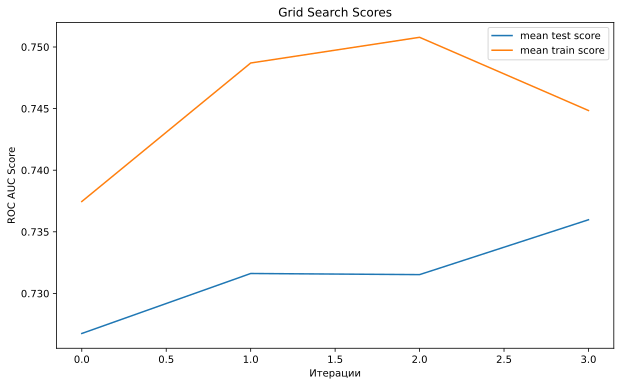

In [131]:
# Логистическая регрессия с настройкой гиперпараметра C
model = LogisticRegression(random_state=RANDOM_STATE, class_weight=class_weights)
column_trans = ColumnTransformer([
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'), features_categories),
    ('std', PowerTransformer(), features_numeric)
], remainder='drop', verbose_feature_names_out=False)

pipeline = Pipeline([
    ('transform', column_trans),
    ('clf', model)
])

logreg_details = train_and_evaluate_model(pipeline,
    "LogisticRegression",
    features_train,
    target_train,
    model,
    {'clf__C': refine_search_range(0.1, 1.0)},
    class_weights
)

### Обучение модели RandomForestClassifier

Модель: RandomForest
ROC AUC: 0.8220
Время выполнения: 43.35 секунд
Лучшие параметры: RandomForestClassifier(class_weight={0: 0.1563801590306702,
                                     1: 0.8436198409693298},
                       max_depth=5, n_estimators=300, random_state=18032024)


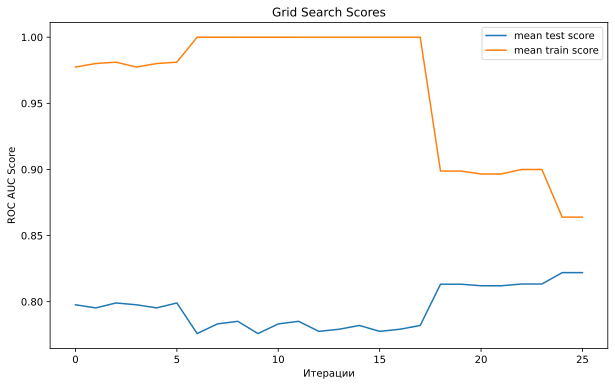

In [132]:
# RandomForest (max_features, max_depth)

# Модель
model = RandomForestClassifier(
    random_state=RANDOM_STATE,
    class_weight=class_weights
)

# Преобразование признаков
column_trans = ColumnTransformer([
    ('ohe', OrdinalEncoder(), features_categories), # кодирование категорий через OrdinalEncoder (для деревьев и бустингов)
    ('std', MaxAbsScaler(), features_numeric), # Стандартизация числовых данных от 0 до 1
], remainder='drop', verbose_feature_names_out=False)

# Pipeline
pipeline = Pipeline([
    ('transform', column_trans), # трансформация выборки
    ('clf', model) # модель классификации
])

# Диапазон значений искомого параметра
forest_params = {
    'clf__n_estimators': [100, 200, 300],
    'clf__max_depth': [5, 10, 15],
    'clf__max_features': ['sqrt', 'log2']
}


random_forest_details = train_and_evaluate_model(pipeline,
    "RandomForest",
    features_train,
    target_train,
    model,
    forest_params,
    class_weights
)

### Обучение модели CatBoostClassifier

Модель: CatBoostClassifier
ROC AUC: 0.9151
Время выполнения: 495.56 секунд
Лучшие параметры: <catboost.core.CatBoostClassifier object at 0x7fb997a5ec40>


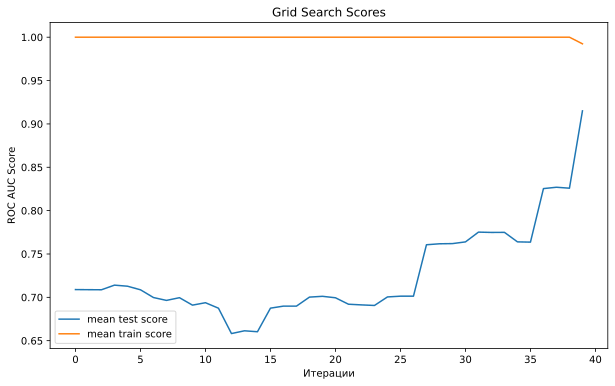

In [133]:
# Создание pipeline для CatBoost

column_trans = ColumnTransformer([
    ('ohe', OrdinalEncoder(), features_categories), # кодирование категорий через OrdinalEncoder (для деревьев и бустингов)
    ('std', MaxAbsScaler(), features_numeric), # Стандартизация числовых данных от 0 до 1
], remainder='drop', verbose_feature_names_out=False)


catboost_pipeline = Pipeline([
    ('transform', column_trans), # трансформация выборки
    ('clf', CatBoostClassifier(random_state=RANDOM_STATE, verbose=False))
])


# Параметры для CatBoost
catboost_params = {
    'clf__depth': [4, 7, 10],
    'clf__learning_rate': [0.1, 0.25, 0.3],
    'clf__n_estimators': [750, 1000, 1500]
}

# Обучение и оценка модели CatBoost
catboost_details = train_and_evaluate_model(
    catboost_pipeline,
    "CatBoostClassifier",
    features_train,
    target_train,
    CatBoostClassifier(random_state=RANDOM_STATE, verbose=False),
    catboost_params,
    class_weights
)

По графику можно сделать следующие выводы:

* В начальных итерациях средняя оценка на тестовом наборе колеблется около отметок 0.70-0.80, что указывает на поиск параметров в пределах значительного разнообразия.
* С увеличением количества итераций средняя оценка на тестовом наборе улучшается, что указывает на приближение к оптимальным параметрам модели.
* В последних итерациях наблюдается резкий взлет средней оценки на тестовом наборе, что указывает на нахождение очень хороших параметров.

In [134]:
catboost_details['best_params']

{'memory': None,
 'steps': [('transform',
   ColumnTransformer(transformers=[('ohe', OrdinalEncoder(),
                                    ['senior_citizen', 'partner', 'dependents',
                                     'type', 'paperless_billing', 'payment_method',
                                     'internet_service', 'online_security',
                                     'online_backup', 'device_protection',
                                     'tech_support', 'streaming_tv',
                                     'streaming_movies', 'multiple_lines']),
                                   ('std', MaxAbsScaler(),
                                    ['monthly_charges', 'total_charges',
                                     'duration_contract'])],
                     verbose_feature_names_out=False)),
  ('clf', <catboost.core.CatBoostClassifier at 0x7fb997a5ec40>)],
 'verbose': False,
 'transform': ColumnTransformer(transformers=[('ohe', OrdinalEncoder(),
                              

## Выбор лучшей модели

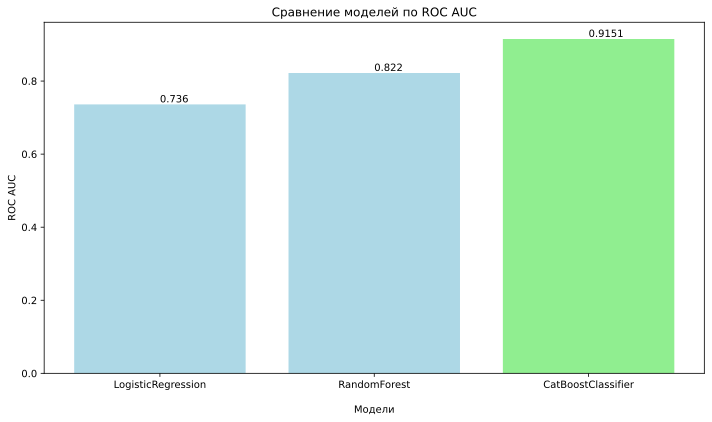

In [135]:
# Создание данных для графика
model_names = list(model_results.keys())
scores = [details['best_score'] for details in model_results.values()]
colors = ['lightblue' if score < max(scores) else 'lightgreen' for score in scores]

# Создание графика
plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, scores, color=colors)

# Добавление подписей к столбцам
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 4), va='bottom')  # va: vertical alignment

# Добавление заголовка и меток осей
plt.title('Сравнение моделей по ROC AUC')
plt.ylabel('ROC AUC')
plt.xlabel('\nМодели')

# Показ графика
plt.tight_layout()
plt.show()

**Выводы из выбора обученной модели**

В результате выбора модели на основе метрики ROC AUC лучшие результат у модели `CatBoostClassifier`
с гиперпараметрами:
* 'depth': 4
* 'learning_rate': 0.25
* 'n_estimators': 750

Показатель ROC AUC равен 0.9151. Время подбора параметров ~495 секунд.

In [141]:
# Находим лучшую модель на основе ROC AUC
best_model_name = max(model_results, key=lambda x: model_results[x]['best_score'])
best_model = model_results[best_model_name]['model']

print(f"Лучшая модель: {best_model_name} с ROC AUC {model_results[best_model_name]['best_score']}")

Лучшая модель: CatBoostClassifier с ROC AUC 0.9150683775557711


In [145]:
# Получение важности признаков
feature_importances = best_model['clf'].get_feature_importance()

# Получение названий признаков
feature_names = features_train.columns

# Создание DataFrame для удобства
importances = pd.DataFrame({'features': feature_names, 'importance': feature_importances})

# Сортировка признаков по важности
importances = importances.sort_values('importance', ascending=False)

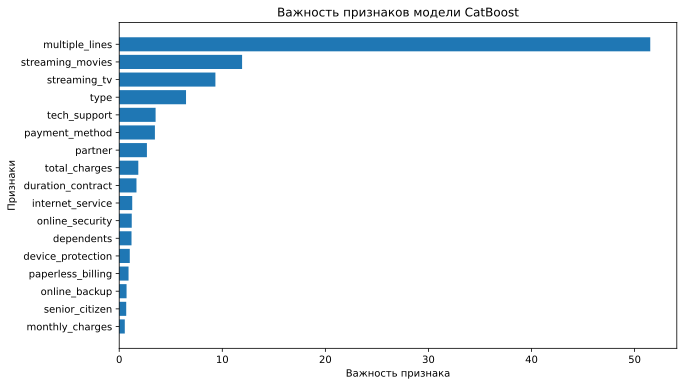

In [146]:
# Создание графика
plt.figure(figsize=(10, 6))
plt.barh(importances['features'], importances['importance'])
plt.xlabel('Важность признака')
plt.ylabel('Признаки')
plt.title('Важность признаков модели CatBoost')
plt.gca().invert_yaxis()  # Инвертирование оси Y для лучшей визуализации
plt.show()

### Тестирование лучшей модели

In [147]:
start_time = time.time()

# Предсказание лучшей модели
predict = best_model.predict(features_test)
predict_proba = best_model.predict_proba(features_test)[:, 1]  # Вероятности для класса 1

finish_time = time.time()
function_time = finish_time - start_time

print(f"Время выполнения предсказания: {function_time} секунд")

Время выполнения предсказания: 0.03866219520568848 секунд


In [148]:
# Расчет "ROC AUC" и времени выполнения предсказания
roc_auc = roc_auc_score(target_test, predict_proba)
print('Показатель ROC AUC:', roc_auc)
print(f'Время предсказания: {function_time} секунд')

Показатель ROC AUC: 0.9282858191606508
Время предсказания: 0.03866219520568848 секунд


Вывод: Цель проекта достигнута. Обученная модель CatBoostClassifier работает с показателем метрики ROC AUC, равной 0.93, что является отличным результатом.

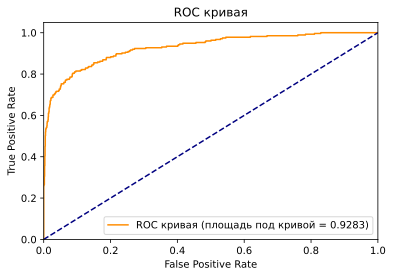

In [149]:
# ROC кривая
fpr, tpr, treshold = roc_curve(target_test, predict_proba)
roc_auc = auc(fpr, tpr)

# Построение графика
plt.plot(
    fpr,
    tpr, color='darkorange',
    label='ROC кривая (площадь под кривой = %0.4f)' % roc_auc
)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC кривая')
plt.legend(loc="lower right")
plt.show()


ROC-кривая демонстрирует значительное выпуклое вверх направление.

Под кривой находится большая часть области прямоугольника, в который она вписана.

Это свидетельствует о том, что модель, как правило, успешно предсказывает целевые значения в большинстве ситуаций.

In [150]:
# Метрика "Accuracy"
print('Показатель Accuracy:', accuracy_score(target_test, predict))

Показатель Accuracy: 0.9233390119250426


Выбранная модель демонстрирует точность примерно 92% в своих предсказаниях классов объектов.

Это важный результат, но необходимо учитывать дисбаланс классов, который может влиять на предсказания в пользу более крупного класса.





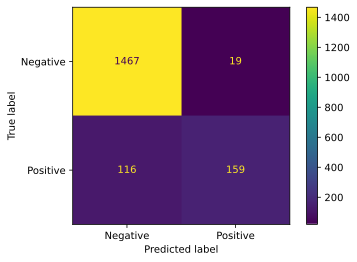

In [151]:
# Матрица ошибок
cm = confusion_matrix(target_test, predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot()
plt.show()

Анализ матрицы ошибок показывает, что протестированная модель правильно предсказывает большую часть класса `0` (на графике горизонталь "Negative", договор не расторгнут).


**Вывод:**

Модель эффективно предскажет пользователя, который не собирается расторгать договор.

## Общий вывод и рекомендации заказчику

**Общий вывод**

Цель данного проекта достигнута успешно.

Рекомендуется использовать модель машинного обучения CatBoostClassifier для предсказания оттока клиентов компании "ТелеДом" в рабочей среде.

Оптимальные гиперпараметры для этой модели:
* 'depth': 4
* 'learning_rate': 0.25
* 'n_estimators': 750

В процессе тестирования модель достигла значительного значения показателя ROC AUC, составившего 0.915, что превышает требуемый уровень в 0.85.

**Рекоммендации заказчику**

Модель `CatBoostClassifier`, с использованием подобранных гиперпараметров, продемонстрировала высокое значение показателя ROC AUC, превышающее установленный порог. В случае необходимости дальнейшего улучшения данного показателя, рекомендуется обратить внимание на возможность применения нейронных сетей, таких как Keras с использованием библиотеки `TensorFlow`. Это может способствовать достижению еще более высоких результатов на тех же данных.

Также рекомендуется пересмотреть требования проекта, включив анализ бизнес-метрик после расчета технических показателей, таких как ROC AUC. Например, оценка финансовых потерь от ухода клиентов может стать более информативной метрикой. Улучшение модели с точки зрения этой бизнес-метрики может потребовать дополнительного обучения модели для более точного предсказания ухода клиентов и минимизации финансовых потерь.

Пожалуйста, обратите внимание на данные, использованные в данном проекте. Неэффективность хранения данных может потребовать оптимизации системы хранения данных.

Например, параметр TotalCharges из файла contract_new.csv имеет тип данных object, хотя содержит числовые значения с плавающей точкой. Более того, категориальные бинарные признаки, такие как PaperlessBilling из файла contract_new.csv, хранятся как тип object, содержащий текстовые значения.

Изменение типа данных этих переменных на bool или даже int8 с бинарными значениями сделает таблицы легче для обработки без потери информативности.

Кроме того, следует обратить внимание на пропуски в данных о клиентах. Эта проблема может быть неочевидной при использовании разрозненных таблиц, но становится заметной при их объединении. Иными словами, некоторые объекты не содержат информации о некоторых продуктах, которые используют клиент





Необходимо учитывать, что значительная часть признаков, присутствующих в исходных датафреймах, неприменима для использования в моделях машинного обучения из-за выявленной мультиколлинеарности и недостаточной корреляции с целевым признаком. После проведения тщательного исследовательского анализа были отобраны следующие признаки для дальнейшего рассмотрения:

* Целевой признак: `active_contract`. Этот атрибут олицетворяет собой наличие или отсутствие активного договора с клиентом. Возможно, целесообразно сохранить его в виде бинарной переменной в используемой системе хранения данных ввиду его высокой информативности и значимости.
* Категориальные признаки: `multiple_lines`, `paperless_billing`, `payment_method`, `tech_support`, `internet_service`.
* Числовые признаки: `total_charges`, `duration_contract`.

**Выводы о проделанной работе**

В данном исследовании были применены широко используемые алгоритмы машинного обучения, включая логистическую регрессию (LogisticRegression), регрессор случайного леса (RandomForestRegressor) и классификатор CatBoost (CatBoostClassifier). Из этих, исключительно CatBoostClassifier демонстрировал производительность выше установленного минимального критерия по показателю ROC AUC. Прогнозируется, что для успешного применения данной модели в промышленных условиях на аналогичных наборах данных будет полезно использование методов кросс-валидации и оптимизация гиперпараметров через конвейеры (Pipeline) и HalvingGridSearchCV.

Процесс достижения целей исследования включал в себя следующие шаги:

1. Конфигурация и подготовка среды Jupyter Notebook, обновление и установка необходимых библиотек, а также загрузка и настройка библиотек, необходимых для проекта. Оптимизация визуализации контента и введение глобальных переменных для содействия в исследовании.
2. Импортирование и верификация данных из соответствующих источников.
3. Выполнение эксплоративного анализа данных и предварительной обработки для датафреймов contract_new, personal_new, internet_new, и phone_new.
4. Интеграция исходных датафреймов в единую структуру данных, с последующим выделением обучающих подвыборок для дальнейшего анализа.
5. Эксплоративный анализ и предобработка обучающей подвыборки, включая анализ мультиколлинеарности и корреляционный анализ, а также отбор признаков для обучения.
6. Подготовка данных для процесса обучения алгоритмов.
7. Обучение моделей машинного обучения, включая LogisticRegression, RandomForestRegressor, и CatBoostClassifier.
8. Отбор и тестирование оптимальной модели на основе показателей ROC AUC.
9. Формулирование заключительных выводов и рекомендаций для заказчика.